# 2. Wrangle the Raster Data (3 layers)
# Part 3: MACA v2 THREDDS - download 2 climate scenarios

In [1]:
# Download stored variables from previous notebooks

# Variables from study area download
# Project data directory
%store -r habitat_suitability_data_dir 
# Site gdfs
%store -r comanche_grassland_gdf pawnee_grassland_gdf 

In [2]:
# Prepare for download Part 1 of 1
## Import packages that will help with...

# Reproducible file paths
import os # Reproducible file paths
import pathlib # Find the home folder

# Find files by pattern
import matplotlib.pyplot as plt # Overlay pandas (vector) and xarry (raster) plots 
import rioxarray as rxr # Work with geospatial raster data

# Work with tabular, vector, and raster data
import geopandas as gpd # work with vector data
import numpy as np # numerical computing
import pandas as pd # Group and aggregate
import xarray as xr # Adjust images

In [3]:
# Create function  that converts longitude that is in the 0-360 
# range, to the -180 to 180 range 
def convert_longitude(longitude):
    """ Convert logitude range from  0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

# Create list to save data arrays back to
maca_da_list = []

# Iterate through multiple sites or study areas
for site_name, site_gdf in {
    'comanche':comanche_grassland_gdf,'pawnee':pawnee_grassland_gdf}.items():
    # Iterate through multiple variables, e.g. precipitation
    for variable in ['pr']:
        # Iterate through start years and end years
        for scenario, start_year in {
            'historical': 2000, 'rcp85': 2091}.items():
            end_year = start_year + 4
            # Define template url for MACA v2 download
            maca_url = (
                'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2'
                f'/CCSM4/macav2metdata_{variable}_CCSM4_r6i1p1_'
                f'{scenario}_{start_year}_{end_year}_CONUS_monthly.nc')
            # Connect to the raster image
            maca_da = xr.open_dataset(maca_url).squeeze().precipitation
            # Get the study bounds
            bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
            # Apply function convert_longitude to convert longitude
            maca_da = maca_da.assign_coords(
                lon = ('lon', 
                [convert_longitude(l) for l in maca_da.lon.values]))
            # Set spatial dimensions - need lon = x-axis and lat = y-axis.
            maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            # Crop the raster image to the bounds of the study area(s)
            maca_da = maca_da.rio.clip_box(*bounds)
            # Append the data array to the list
            maca_da_list.append(dict(
                site_name = site_name,
                variable = variable,
                scenario = scenario,
                start_year = start_year,
                da = maca_da
                ))      
                     
# Convert maca_da_list to df, call maca_df to see it
maca_df = pd.DataFrame(maca_da_list)
maca_df.da.values

array([<xarray.DataArray 'precipitation' (time: 60, lat: 23, lon: 43)> Size: 237kB
       [59340 values with dtype=float32]
       Coordinates:
         * lat      (lat) float64 184B 36.98 37.02 37.06 37.1 ... 37.81 37.85 37.9
         * time     (time) object 480B 2000-01-15 00:00:00 ... 2004-12-15 00:00:00
         * lon      (lon) float64 344B -104.1 -104.0 -104.0 ... -102.4 -102.4 -102.3
           crs      int64 8B 0
       Attributes:
           long_name:      Monthly Precipitation Amount
           units:          mm
           standard_name:  precipitation
           cell_methods:   time: sum(interval: 24 hours): sum over days
           comments:       Total monthly precipitation at surface: includes both liq...
           _ChunkSizes:    [ 10  44 107]                                               ,
       <xarray.DataArray 'precipitation' (time: 60, lat: 23, lon: 43)> Size: 237kB
       [59340 values with dtype=float32]
       Coordinates:
         * lat      (lat) float64 1

### For what I'm about to do I know it's not DRY

I'm having issues figuring out how to repeatedly do this, and 
there's probably an easier way like not making a dataframe, but 
I couldn't get the code to work otherwise. I want to be able to 
harmonize and this is the only way I can figure hout how to make 
that happen.

In [4]:
# Pull out a row of the dataframe in order to try to plot

#Pull out Comanche maca scenarios
maca_comanche_2000_da = (
    maca_df[(maca_df.start_year==2000) & (maca_df.site_name=='comanche')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum - because that info on the plant species was found
    .min('year')
)

maca_comanche_2091_da = (
    maca_df[(maca_df.start_year==2091) & (maca_df.site_name=='comanche')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum - because that info on the plant species was found
    .min('year')
)


In [5]:
# Pull out Pawnee maca scenarios
maca_pawnee_2000_da = (
    maca_df[(maca_df.start_year==2000) & (maca_df.site_name=='comanche')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum - because that info on the plant species was found
    .min('year')
)

maca_pawnee_2091_da = (
    maca_df[(maca_df.start_year==2091) & (maca_df.site_name=='comanche')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum - because that info on the plant species was found
    .min('year')
)


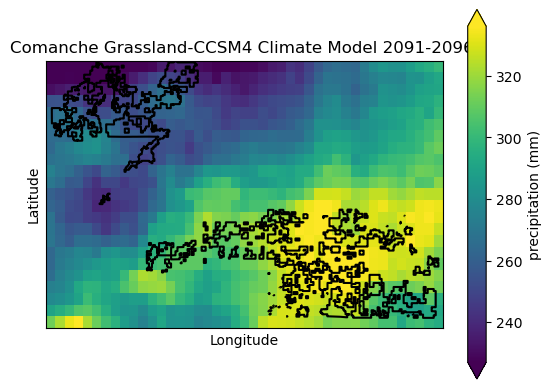

In [6]:
# Test by plotting 1 climate scenario on 1 study area
maca_comanche_2091_da.plot(
    cbar_kwargs={"label": "precipitation (mm)"},
    robust=True
)
# Overlay the boundary of the same study area
comanche_grassland_gdf.boundary.plot(ax=plt.gca(),
    color='black').set(
        title='Comanche Grassland-CCSM4 Climate Model 2091-2096 ',
        xlabel='Longitude', 
        ylabel='Latitude',
        xticks=[],
        yticks=[] 
    )
plt.show()

## Comanche CCSM4 Climate model, rcp85, 2091-2096 is lower 
## resolution than the other raster data downloaded, but did plot 
## correctly. Stark difference between upper and lower unit.

There is a stark difference betweent he upper Timpas Unit with 
less precipitation and the lower, Carrizo, with higher precipitation.
While they visually apear stark the full range of the precipitation bar
in mm is within the Rocky Mountain Juniper's suitable range (228.6 -660.4mm).
Further conclusions can be drawn during the habitat suitability model, 
however it needs to be kept in mind that this should not be the reference 
raster to harmonize to because it is the lowest resolution of the 3 raster 
layers downloaded.


In [8]:
%store maca_df maca_comanche_2091_da maca_comanche_2000_da
%store  maca_pawnee_2091_da maca_pawnee_2000_da

Stored 'maca_df' (DataFrame)
Stored 'maca_comanche_2091_da' (DataArray)
Stored 'maca_comanche_2000_da' (DataArray)
Stored 'maca_pawnee_2091_da' (DataArray)
Stored 'maca_pawnee_2000_da' (DataArray)
